In [1]:
import numpy as np
import torch

torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm import tqdm

In [2]:
def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1 + x / 3
    return y


def cost(x):
    return -(0.1 * objective(x) + objective(x - 4)) / 3 + x / 3 - 0.5


lb = -5
ub = 5

bounds = torch.tensor([[lb], [ub]], dtype=torch.float)

xs = torch.linspace(lb, ub, 201)

objective_ys = objective(xs)
cost_ys = cost(xs)

In [3]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [4]:
n = 3
torch.manual_seed(0)
train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(n)

train_utility = objective(train_x)
train_cost = cost(train_x)

utility_model, utility_likelihood = fit_gp_model(train_x.unsqueeze(-1), train_utility)
cost_model, cost_likelihood = fit_gp_model(train_x.unsqueeze(-1), train_cost)

In [5]:
with torch.no_grad():
    utlity_pred_dist = utility_likelihood(utility_model(xs))
    utility_pred_mean = utlity_pred_dist.mean
    utility_pred_lower, utility_pred_upper = utlity_pred_dist.confidence_region()

    cost_pred_dist = cost_likelihood(cost_model(xs))
    cost_pred_mean = cost_pred_dist.mean
    cost_pred_lower, cost_pred_upper = cost_pred_dist.confidence_region()

In [6]:
ei = botorch.acquisition.analytic.ExpectedImprovement(
    model=utility_model,
    best_f=train_utility[train_cost <= 0].max(),
)

constrained_ei = botorch.acquisition.analytic.ConstrainedExpectedImprovement(
    model=botorch.models.model_list_gp_regression.ModelListGP(
        utility_model, cost_model
    ),
    best_f=train_utility[train_cost <= 0].max(),
    objective_index=0,
    constraints={1: [None, 0]},
)

with torch.no_grad():
    ei_score = ei(xs[:, None, None])
    constrained_ei_score = constrained_ei(xs[:, None, None])

In [7]:
normal = torch.distributions.Normal(cost_pred_mean, cost_pred_dist.stddev)
feasible_prob = normal.cdf(torch.zeros(1))

assert torch.isclose(ei_score * feasible_prob, constrained_ei_score, atol=1e-3).all()

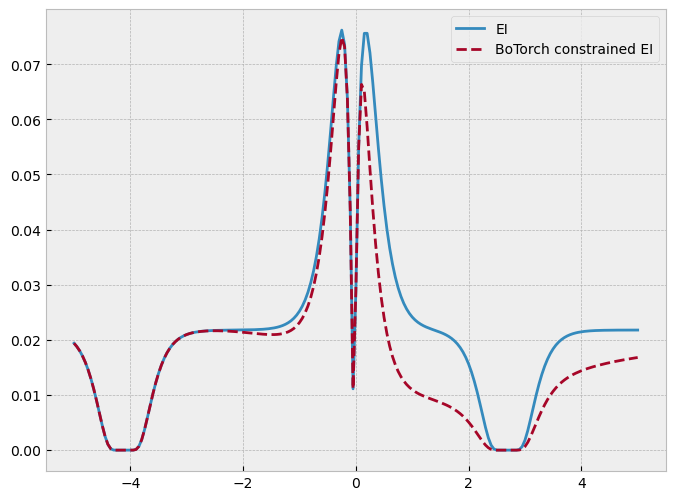

In [8]:
plt.plot(xs, ei_score, label="EI")
plt.plot(
    xs,
    constrained_ei_score,
    label="BoTorch constrained EI",
    linestyle="--",
)

plt.legend();